Sentiment Analysis (SA) is the broad field that aim at quantifying natural language emanating from human. This task has become more and more interesting as CPU power and cost diminished and has artificial intelligence (AI) rose.

Basic sentiment analysis aimed at quantifying what proportion of word are "positive" and what proportion of word are "negative" in a text. Before the introduction of Large Language Models, and even before the introduction of the first efficient deep learning systems for natural language processing (NLP), the main way to do SA was to create a dictionary with each word and its weight of negativity and positivity.

Before [Loughran and McDonald (LM) work](https://sci-hub.live/https://doi.org/10.1111/j.1540-6261.2010.01625.x), SA for Financial Statements was done with the Harvard Psychology dictionnary. Nonetheless, in this dictionary, words like "tax" and "liabilities" were highly negative in the common life whereas they are just technical words in finance.

To allow better SA for financial statements, LM created their own dictionary of words and divided the sentiment between 7 different categories (positivity, negativity, uncertainty, weak modals, strong modals...), also allowing some words to not have any conotation (Abacus is just a financial product, not positive, not negative).

In this notebook we propose to help you build your own Loughran McDonald sentiment analyser with python.

This notebook aim at introducing sentiment analysis and coding to beginners and lack a lot of optimisation and advanced elements (API, further regular expression, dataframes etc.). Feel free to create a more advanced one for more advanced students in programming.

What your folder should look like at the end:

My Drive/WorkingFolder:

├── `<copy_of_this_google_collab>`.ipynb

├── Loughran-McDonald_MasterDictionary_1993-2021.csv


├── reports

│..........├── 2010.txt

│..........├── 2011.txt

│..........├── 2012.txt

│..........├── 2013.txt

│..........├── 2014.txt

│..........├── 2015.txt

│..........├── 2016.txt

│..........├── 2017.txt

│..........├── 2018.txt

│..........├── 2019.txt

│..........└── 2020.txt


# Loughran McDonald SEC Sentiment Analysis gap-fill

## Load Loughran McDonald dictionary and set up

In this part, we will need to download the [Loughran-McDonald_MasterDictionary_1993-2021.csv](https://drive.google.com/file/d/1s_NrXEc_3ugDnTXzcapwi25fzEZRRl0i/view?usp=drive_link) and put it in the same folder on our drive than this Google Colaboratory file.

Then, write down the path to this folder (eache nested folder should be separated with a `/`).

In [5]:
# Connect to your Google Drive so that this Google Colaboratory has access to your documents
PATH_TO_THIS_GOOGLE_COLLABORATORY = '/content/drive/My Drive/EDHEC'

# Allow Google to access your drive
from google.colab import drive
drive.mount('/content/drive')

# Tell this Google Colaboratory that we will work in the indicated folder and no other
import os
os.makedirs(PATH_TO_THIS_GOOGLE_COLLABORATORY, exist_ok=True) # Ensure the directory exists

Mounted at /content/drive


In [6]:
import csv

# List the seven sentiments of LM
SENTIMENTS = ["Negative", "Positive", "Uncertainty", "Litigious", "Strong_Modal", "Weak_Modal", "Constraining"]

# Empty dictionary to contain each row of LM csv
WORDS_DICTIONARY = {}

# We open the file and for each row we create an entry in the dictionary
with open(PATH_TO_THIS_GOOGLE_COLLABORATORY + "/Loughran-McDonald_MasterDictionary_1993-2021.csv") as csv_file:
    lm_csv_reader = csv.DictReader(csv_file, delimiter=",")
    for row in lm_csv_reader:
        if any([row[s] != 0 for s in SENTIMENTS]):
            WORDS_DICTIONARY[row["Word"]] = row

In [7]:
# Let show the first 10 entries of the dictionary
print(f"Master dictionary has {len(WORDS_DICTIONARY)} words.")
for i, k in enumerate(WORDS_DICTIONARY):
    if i < 10:
        print(k, WORDS_DICTIONARY[k])

Master dictionary has 86531 words.
AARDVARK {'Word': 'AARDVARK', 'Seq_num': '1', 'Word Count': '354', 'Word Proportion': '1.5500800963911755e-08', 'Average Proportion': '1.4225999551502054e-08', 'Std Dev': '3.815485513159406e-06', 'Doc Count': '99', 'Negative': '0', 'Positive': '0', 'Uncertainty': '0', 'Litigious': '0', 'Strong_Modal': '0', 'Weak_Modal': '0', 'Constraining': '0', 'Syllables': '2', 'Source': '12of12inf'}
AARDVARKS {'Word': 'AARDVARKS', 'Seq_num': '2', 'Word Count': '3', 'Word Proportion': '1.3136272003315047e-10', 'Average Proportion': '8.653817188771135e-12', 'Std Dev': '9.241713594106557e-09', 'Doc Count': '1', 'Negative': '0', 'Positive': '0', 'Uncertainty': '0', 'Litigious': '0', 'Strong_Modal': '0', 'Weak_Modal': '0', 'Constraining': '0', 'Syllables': '2', 'Source': '12of12inf'}
ABACI {'Word': 'ABACI', 'Seq_num': '3', 'Word Count': '9', 'Word Proportion': '3.940881600994514e-10', 'Average Proportion': '1.1696785858863093e-10', 'Std Dev': '5.2904646914222574e-08', '

Congratulations ! You successfully loaded the Loughran McDonald dictionary. You should see that there are 86531 words starting with `AARDVARK`. The first word with a weight is `ABANDON` with `2009`in the `Negativity` field. Indeed 'abandon', in case of financial statement, is rather negative.

Loughran-McDonal dictionary is based on 50 000 SEC 10-K reports from 1993 to 2008. It contains every word that appeared at least in 5% of these reports.

## Load and refine SEC reports for Apple

There are plenty way of connecting to the SEC EDGAR API. In our case we will be simple and copy/paste manually the reports we want in a folder `reports` in our working directory.

For this example, you can load the 11 reports of Microsoft from 2010 to 2020 [here](https://drive.google.com/drive/folders/1qX3HQEfLkNY5kDuS3KlNjTGnrm96dQ5C?usp=drive_link). Please set them in a folder `reports` in your working directory.

If you want to analyze another company:
- Go to [SEC EDGAR manual interface](https://www.sec.gov/edgar/searchedgar/companysearch)
- Search a company
- On the right pannel, click on `10-K (annual reports) and 10-Q (quarterly reports)` to open it
- Click on `View all 10-Ks and 10-Qs`
- In the `Fillings` section, expand the date up to the moment you want to analyze
- You can open each `Annual report [Section 13 and 15(d), not S-K Item 405]`
- Select everything (`cntrl + A` 😉), copy and paste it in a `<year of the 10k>.txt` file with the year instead of the `<year of the 10k>`
- Put the file in the folder `reports` (and don't forget to remove the files from other companies)

In [8]:
STARTING_YEAR = 2010 # Year of the first 10K report
ENDING_YEAR = 2020 # Year of the last report

list_of_reports = []

for year in range(STARTING_YEAR, ENDING_YEAR+1):
  with open(PATH_TO_THIS_GOOGLE_COLLABORATORY + f"/reports/{year}.txt", "r") as f:
    report = f.read()
    list_of_reports.append(report)

In [9]:
import re

print("Total number of characters:", sum([len(x) for x in list_of_reports]))
print("Characters per report:", [len(x) for x in list_of_reports])
print("Total number of words:", sum([len(re.findall("\w+", x)) for x in list_of_reports]))
print("Words per report:", [len(re.findall("\w+", x)) for x in list_of_reports])
print("-----------------------")
print(f"Extract of first report (year {STARTING_YEAR}):\n", list_of_reports[0][:1000])

Total number of characters: 3956717
Characters per report: [314099, 322957, 331953, 335546, 360706, 360290, 367652, 390058, 401906, 383406, 388144]
Total number of words: 556552
Words per report: [45415, 46225, 47970, 48719, 52437, 52162, 53520, 52831, 54023, 51315, 51935]
-----------------------
Extract of first report (year 2010):
 10-K 1 d10k.htm ANNUAL REPORT ON FORM 10-K
Table of Contents
UNITED STATES

SECURITIES AND EXCHANGE COMMISSION

Washington, D.C. 20549

 

FORM 10-K

 

 

x	
ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934

For the Fiscal Year Ended June 30, 2010

OR

 

¨	
TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934

For the Transition Period From                  to                 

Commission File Number 0-14278

 

MICROSOFT CORPORATION

 

 

WASHINGTON	 	91-1144442
(STATE OF INCORPORATION)	 	(I.R.S. ID)
ONE MICROSOFT WAY, REDMOND, WASHINGTON 98052-6399

(425) 882-8080

www.microsoft.c

## Analyse the reports

We create a dataframe (a table) that will contain the information for each report.

In [40]:
import pandas as pd

df_columns = [
    "Year",
    "Number_of_words",
    'Negative_absolute',
    'Negative_proportion',
    'Positive_absolute',
    'Positive_proportion',
    'Uncertainty_absolute',
    'Uncertainty_proportion',
    'Litigious_absolute',
    'Litigious_proportion',
    'Strong_Modal_absolute',
    'Strong_Modal_proportion',
    'Weak_Modal_absolute',
    'Weak_Modal_proportion',
    'Constraining_absolute',
    'Constraining_proportion'
]

compilation_df = pd.DataFrame(columns=df_columns)
compilation_df.head()

,Year,Number_of_words,Negative_absolute,Negative_proportion,Positive_absolute,Positive_proportion,Uncertainty_absolute,Uncertainty_proportion,Litigious_absolute,Litigious_proportion,Strong_Modal_absolute,Strong_Modal_proportion,Weak_Modal_absolute,Weak_Modal_proportion,Constraining_absolute,Constraining_proportion


For each word of each report we will check if it belongs to the LM dictionary. If it does we will both count that this word appear once but also that this sentiment appear once.

Then we will divide it by the number of words to get the proportion of words of each type in order to not be influenced by the report size.

We use the `re` library to extract all the words of the document.

In [41]:
for i, report in enumerate(list_of_reports):
  words_list = [x.upper() for x in re.findall("\w+", report)]
  number_of_words = len(words_list)

  output_dict = {k: 0 for k in df_columns}
  sentiment_count = {k: 0 for k in SENTIMENTS}

  for word in words_list:
    if word in WORDS_DICTIONARY: # If the word is in LM dictionary
      for sentiment in SENTIMENTS: # We go through the 7 sentiments
        if int(WORDS_DICTIONARY[word][sentiment]) != 0: # If the sentiment cell is not null
          sentiment_count[sentiment] += 1 # Then we add +1 to its occurence

  # print(sentiment_count)
  # We fill the dictionary to output with the correct values
  output_dict['Year'] = STARTING_YEAR + i
  output_dict['Number_of_words'] = number_of_words
  output_dict['Negative_absolute'] = sentiment_count['Negative']
  output_dict['Negative_proportion'] = sentiment_count['Negative']/number_of_words
  output_dict['Positive_absolute'] = sentiment_count['Positive']
  output_dict['Positive_proportion'] = sentiment_count['Positive']/number_of_words
  output_dict['Uncertainty_absolute'] = sentiment_count['Uncertainty']
  output_dict['Uncertainty_proportion'] = sentiment_count['Uncertainty']/number_of_words
  output_dict['Litigious_absolute'] = sentiment_count['Litigious']
  output_dict['Litigious_proportion'] = sentiment_count['Litigious']/number_of_words
  output_dict['Strong_Modal_absolute'] = sentiment_count['Strong_Modal']
  output_dict['Strong_Modal_proportion'] = sentiment_count['Strong_Modal']/number_of_words
  output_dict['Weak_Modal_absolute'] = sentiment_count['Weak_Modal']
  output_dict['Weak_Modal_proportion'] = sentiment_count['Weak_Modal']/number_of_words
  output_dict['Constraining_absolute'] = sentiment_count['Constraining']
  output_dict['Constraining_proportion'] = sentiment_count['Constraining']/number_of_words

  # And we add the dictionary as a line to our dataframe
  temp_df = pd.DataFrame([output_dict])
  compilation_df = pd.concat([compilation_df, temp_df], ignore_index=True)

In [42]:
# Check that the dataframe filled correctly
compilation_df.head(12)

,Year,Number_of_words,Negative_absolute,Negative_proportion,Positive_absolute,Positive_proportion,Uncertainty_absolute,Uncertainty_proportion,Litigious_absolute,Litigious_proportion,Strong_Modal_absolute,Strong_Modal_proportion,Weak_Modal_absolute,Weak_Modal_proportion,Constraining_absolute,Constraining_proportion
0,2010,45415,563,0.012397,331,0.007288,512,0.011274,373,0.008213,89,0.001960,214,0.004712,209,0.004602
1,2011,46225,544,0.011769,356,0.007701,556,0.012028,391,0.008459,98,0.002120,244,0.005279,197,0.004262
2,2012,47970,648,0.013508,352,0.007338,598,0.012466,397,0.008276,90,0.001876,273,0.005691,262,0.005462
3,2013,48719,686,0.014081,347,0.007122,581,0.011926,408,0.008375,88,0.001806,271,0.005563,268,0.005501
4,2014,52437,730,0.013921,362,0.006904,600,0.011442,456,0.008696,83,0.001583,286,0.005454,246,0.004691
5,2015,52162,816,0.015644,366,0.007017,598,0.011464,452,0.008665,74,0.001419,276,0.005291,269,0.005157
6,2016,53520,867,0.016200,396,0.007399,640,0.011958,421,0.007866,93,0.001738,289,0.005400,305,0.005699
7,2017,52831,821,0.015540,416,0.007874,624,0.011811,428,0.008101,88,0.001666,297,0.005622,291,0.005508
8,2018,54023,817,0.015123,415,0.007682,624,0.011551,476,0.008811,76,0.001407,349,0.006460,302,0.005590
9,2019,51315,768,0.014966,413,0.008048,634,0.012355,443,0.008633,58,0.001130,361,0.007035,279,0.005437


## Vizualize

Finally we can vizualize the result to see the variation of the number of word in each sentiment and their proportion in the report year after year.

<Axes: xlabel='Year'>

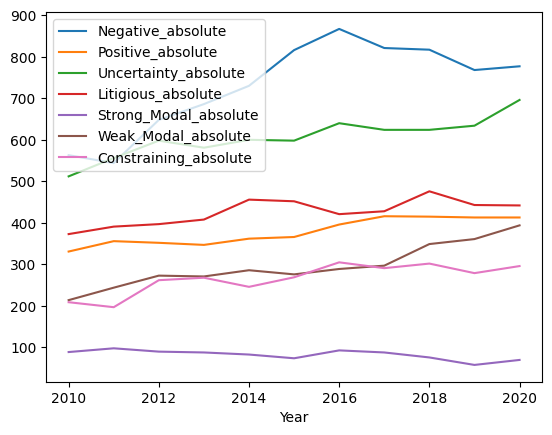

In [43]:
compilation_df[['Year', 'Negative_absolute', 'Positive_absolute', 'Uncertainty_absolute', 'Litigious_absolute', 'Strong_Modal_absolute', 'Weak_Modal_absolute', 'Constraining_absolute']].plot(x = 'Year')

<Axes: xlabel='Year'>

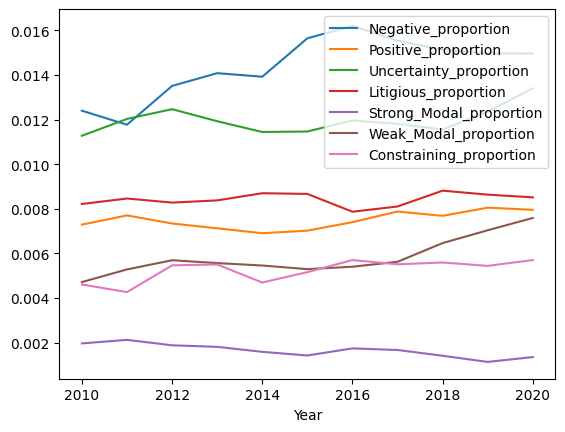

In [44]:
compilation_df[['Year', 'Negative_proportion', 'Positive_proportion', 'Uncertainty_proportion', 'Litigious_proportion', 'Strong_Modal_proportion', 'Weak_Modal_proportion', 'Constraining_proportion']].plot(x = 'Year')